In [1]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from copy import deepcopy
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

from Models import tcn
from train.Dataset import CustomDataset
from train.TrainHelpers import train_model, plot_loss_graph, encode_data, train_svm
from train.TestHelpers import test_model, calculate_accuracy

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps") 
else:
    device = torch.device("cpu")
print(device)

cuda


In [2]:
### PARAMETERS ###
dataset_ver = '3w05s_Rarm'
n_input = 9
n_hidden = 360
seed = 345

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

x_train = np.load(f'Generated_Datasets/train_data_{dataset_ver}.npy')
x_val = np.load(f'Generated_Datasets/val_data_{dataset_ver}.npy')
x_test = np.load(f'Generated_Datasets/test_data_{dataset_ver}.npy')

y_train = np.load(f'Generated_Datasets/train_labels_{dataset_ver}.npy')
y_val = np.load(f'Generated_Datasets/val_labels_{dataset_ver}.npy')
y_test = np.load(f'Generated_Datasets/test_labels_{dataset_ver}.npy')

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)

(15407, 60, 9)
(15407,)
(2202, 60, 9)


(15407, 60, 9) (4403, 60, 9) (2202, 60, 9)


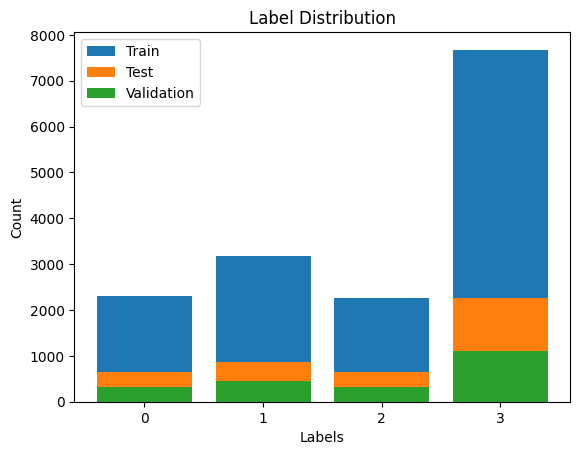

In [4]:
# Check Dataset
print(x_train.shape, x_test.shape, x_val.shape)
unique_labels_train, label_counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, label_counts_val = np.unique(y_val, return_counts=True)
unique_labels_test, label_counts_test = np.unique(y_test, return_counts=True)

plt.bar(unique_labels_train, label_counts_train, label='Train')
plt.bar(unique_labels_test, label_counts_test, label='Test')
plt.bar(unique_labels_val, label_counts_val, label='Validation')

# Set the x-axis tick labels
plt.xticks(unique_labels_train, unique_labels_train)

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.legend()
plt.show()

In [5]:
### Declare Dataloaders
train_dataset = CustomDataset("train", dataset_ver)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataset = CustomDataset("val", dataset_ver)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)
test_dataset = CustomDataset("test", dataset_ver)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [6]:
for X, y in train_dataloader:
    print(f'{X.shape=}')
    print(f'{y.shape=}')
    break   

X.shape=torch.Size([1, 60, 9])
y.shape=torch.Size([1])


In [7]:
class tcn_classifier(nn.Module):
    def __init__(self, num_inputs, tcn_channels):
        super(tcn_classifier, self).__init__()

        # if tcn_channels[-1] != mlp_layer_dims[0]:
        #     raise ValueError("Output of TCN must match input to MLP!")

        self.tcn = tcn.TCN(num_inputs=num_inputs,
                            num_channels=tcn_channels,
                            causal=False,
                            input_shape='NLC')
        # self.mlp = nn.Sequential()

        # for i in range(len(mlp_layer_dims)-1):
        #     self.mlp.add_module(f'fc{i+1}', nn.Linear(mlp_layer_dims[i], mlp_layer_dims[i+1]))


    def forward(self, x):
        x = self.tcn(x)
        # x = self.mlp(x)
        # print(x.shape)
        return x[0][-1]

In [8]:
tcn_model = tcn_classifier(9, [128, 64, 32, 16, 4])

In [9]:
print(tcn_model)

tcn_classifier(
  (tcn): TCN(
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          9, 128, kernel_size=(4,), stride=(1,), padding=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (conv2): ParametrizedTemporalConv1d(
          128, 128, kernel_size=(4,), stride=(1,), padding=(1,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (downsample): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): ParametrizedTemporalConv1d(
          128, 64, kernel_size=(4,), stride=(1,), p

In [10]:
for X, y in train_dataloader:
    out = tcn_model.forward(X)
    print(out.shape)
    break   

torch.Size([4])


In [11]:
def train_TCN(model, learning_rate, num_epochs, patience):
    optimizer = optim.Adam(model.parameters(),
                            lr=learning_rate,
                            betas=(0.9, 0.999),
                            eps=1e-8)

    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    best_val_acc = 0
    es_count = 0

    for epoch in range(num_epochs):
        if es_count < patience:
            print(f'Starting Epoch {epoch+1}...')
            model.train()

            train_preds = []
            train_labels = []

            for train_X, train_y in tqdm(train_dataloader):
                optimizer.zero_grad()
                
                train_output = model(train_X)

                train_loss = criterion(train_output, train_y[0].type(torch.LongTensor))
                train_loss.backward()
                optimizer.step()

                train_preds.append(torch.argmax(train_output))
                train_labels.append(train_y)
            
            train_losses.append(train_loss.item())
            print(f'Train Loss = {train_losses[-1]}')

            train_acc = accuracy_score(train_labels, train_preds)
            print(f'Train Acc = {train_acc}')

            model.eval()

            val_preds = []
            val_labels = []

            for val_X, val_y in tqdm(val_dataloader):
                val_output = model(val_X)

                val_preds.append(torch.argmax(val_output))
                val_labels.append(val_y)

            val_losses.append(criterion(val_output, val_y[0].type(torch.LongTensor)))
            print(f'Val Loss = {val_losses[-1]}')

            val_acc = accuracy_score(val_labels, val_preds)
            print(f'Val Acc = {val_acc}')

            if val_acc > best_val_acc:
                torch.save(deepcopy(model.state_dict()), 'ML_Models/noncausal_tcn_state_20e.pt')
                best_val_acc = val_acc
                es_count = 0
            
            es_count += 1
        
        else:
            print('Early Stopping...')

    return train_losses, val_losses


In [13]:
train_losses, val_losses = train_TCN(tcn_model, 1e-3, 20, 5)

Starting Epoch 1...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.002638789126649499
Train Acc = 0.7411566171220874


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.04242444783449173
Val Acc = 0.846503178928247
Starting Epoch 2...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.016135934740304947
Train Acc = 0.852859090024015


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.22268015146255493
Val Acc = 0.8823796548592189
Starting Epoch 3...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.07983045279979706
Train Acc = 0.8753813201791394


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.2392435520887375
Val Acc = 0.8955495004541326
Starting Epoch 4...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 1.191321849822998
Train Acc = 0.893295255403388


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 1.5899760723114014
Val Acc = 0.9178019981834695
Starting Epoch 5...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.005157499574124813
Train Acc = 0.9021224118906991


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.04741349816322327
Val Acc = 0.9096276112624887
Starting Epoch 6...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.017143631353974342
Train Acc = 0.9074446680080482


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 2.1320252418518066
Val Acc = 0.9173478655767484
Starting Epoch 7...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.0007438276661559939
Train Acc = 0.9136106964366846


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.44043657183647156
Val Acc = 0.9214350590372389
Starting Epoch 8...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 4.529942543740617e-06
Train Acc = 0.9189329525540338


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.0
Val Acc = 0.9209809264305178
Starting Epoch 9...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 5.57245397567749
Train Acc = 0.9215940806127085


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 5.638440416078083e-05
Val Acc = 0.9055404178019982
Starting Epoch 10...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.04308372363448143
Train Acc = 0.9222431362367755


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.17225603759288788
Val Acc = 0.9100817438692098
Starting Epoch 11...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.0002727136597968638
Train Acc = 0.9293178425391057


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 4.911301948595792e-05
Val Acc = 0.9250681198910081
Starting Epoch 12...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 1.15157949924469
Train Acc = 0.9299668981631726


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.39846163988113403
Val Acc = 0.9400544959128065
Starting Epoch 13...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.023619595915079117
Train Acc = 0.9364574544038424


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 3.266281055402942e-05
Val Acc = 0.9405086285195277
Starting Epoch 14...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 1.3112935448589269e-05
Train Acc = 0.9385344324008568


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 3.957670196541585e-05
Val Acc = 0.9427792915531336
Starting Epoch 15...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 7.033323527139146e-06
Train Acc = 0.9400921658986175


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 2.816204309463501
Val Acc = 0.9332425068119891
Starting Epoch 16...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 4.768370445162873e-07
Train Acc = 0.9406763159602778


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.8684839010238647
Val Acc = 0.9336966394187103
Starting Epoch 17...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.0
Train Acc = 0.9445706497046797


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.023267459124326706
Val Acc = 0.9559491371480472
Starting Epoch 18...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.007668343838304281
Train Acc = 0.9495683780099955


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 1.1920928244535389e-07
Val Acc = 0.9187102633969119
Starting Epoch 19...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.00013815402053296566
Train Acc = 0.947296683325761


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 0.03714198246598244
Val Acc = 0.9464123524069028
Starting Epoch 20...


  0%|          | 0/15407 [00:00<?, ?it/s]

Train Loss = 0.0
Train Acc = 0.9521646005062634


  0%|          | 0/2202 [00:00<?, ?it/s]

Val Loss = 2.5748875486897305e-05
Val Acc = 0.9455040871934605


In [14]:
print(train_losses)
print([x.detach().numpy() for x in val_losses])

[0.002638789126649499, 0.016135934740304947, 0.07983045279979706, 1.191321849822998, 0.005157499574124813, 0.017143631353974342, 0.0007438276661559939, 4.529942543740617e-06, 5.57245397567749, 0.04308372363448143, 0.0002727136597968638, 1.15157949924469, 0.023619595915079117, 1.3112935448589269e-05, 7.033323527139146e-06, 4.768370445162873e-07, 0.0, 0.007668343838304281, 0.00013815402053296566, 0.0]
[array(0.04242445, dtype=float32), array(0.22268015, dtype=float32), array(0.23924355, dtype=float32), array(1.5899761, dtype=float32), array(0.0474135, dtype=float32), array(2.1320252, dtype=float32), array(0.44043657, dtype=float32), array(0., dtype=float32), array(5.6384404e-05, dtype=float32), array(0.17225604, dtype=float32), array(4.911302e-05, dtype=float32), array(0.39846164, dtype=float32), array(3.266281e-05, dtype=float32), array(3.9576702e-05, dtype=float32), array(2.8162043, dtype=float32), array(0.8684839, dtype=float32), array(0.02326746, dtype=float32), array(1.1920928e-07, 

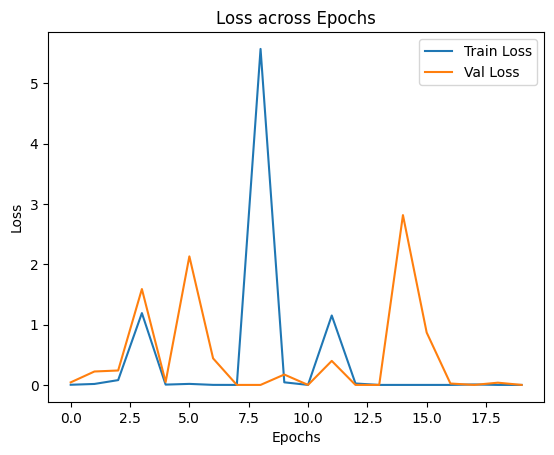

In [15]:
plot_loss_graph(train_losses, [x.detach().numpy() for x in val_losses], 'noncausal_tcn_20e')